In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the required libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
train_data=pd.read_csv('/content/drive/MyDrive/links/jigsaw-toxic-comment-classification-challenge.zip (Unzipped Files)/train.csv.zip (Unzipped Files)/train.csv')

In [ ]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
test_data=pd.read_csv('/content/drive/MyDrive/links/jigsaw-toxic-comment-classification-challenge.zip (Unzipped Files)/test.csv.zip (Unzipped Files)/test.csv')

In [ ]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


EDA

In [ ]:
del train_data['id']
del test_data['id']
print("Training data :",train_data.shape)
print("Test Data:",test_data.shape)
print(train_data.info())

Training data : (159571, 7)
Test Data: (153164, 1)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB
None


Visualization

In [ ]:
output_features=["toxic","severe_toxic","obscene","threat","insult","identity_hate"]#values-->converting array


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


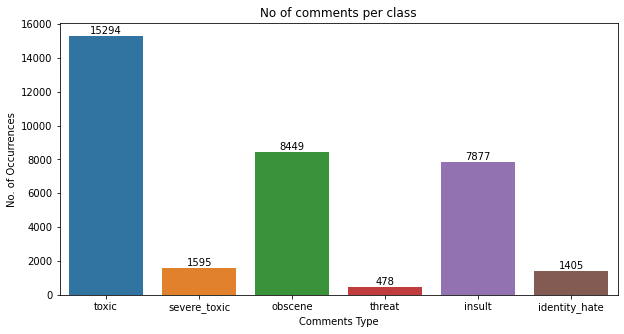

In [ ]:
import seaborn as sns
value_counts=train_data[output_features].sum() #sum--->It contains index and values Eg:toxic 15294
plt.figure(figsize=(10,5))
ax=sns.barplot(value_counts.index,value_counts.values)

plt.title("No of comments per class")
plt.xlabel('Comments Type')
plt.ylabel('No. of Occurrences')


rect=ax.patches
label=value_counts.values #array([15294,  1595,  8449,   478,   478,  7877,  1405])
for rects,labels in zip(rect,label):
    height=rects.get_height()
    ax.text(rects.get_x()+rects.get_width()/2,height+5,labels,ha='center',va='bottom')

plt.show()

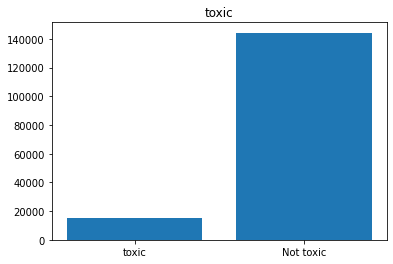

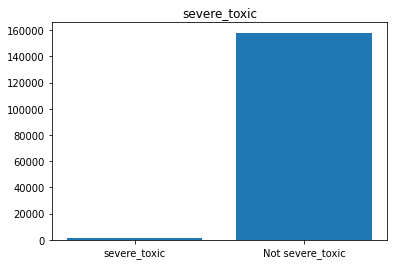

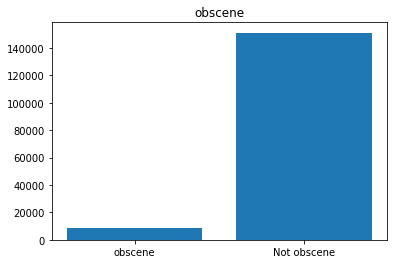

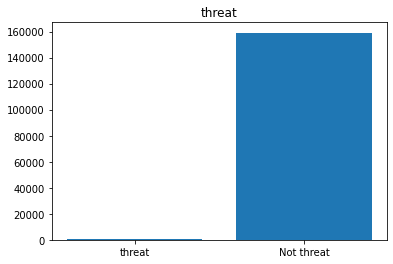

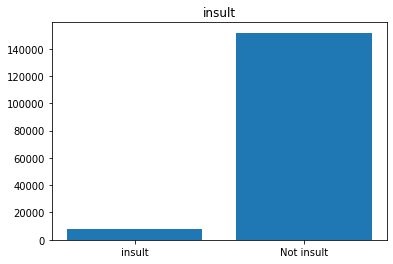

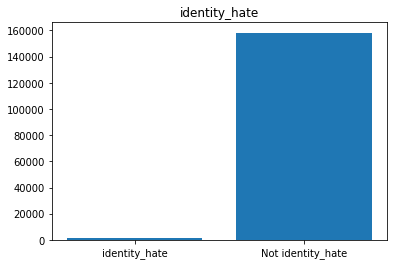

In [ ]:
for i,col in enumerate(["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]):
    plt.title(col)
    plt.bar([col,"Not "+col], np.sort(train_data[col].value_counts()))
    plt.show()

In [ ]:
train_data=train_data.reindex(np.random.permutation(train_data.index))
print(train_data.head(2))

                                            comment_text  ...  identity_hate
21811  Memento Mori \n\nWhat's your source that tells...  ...              0
28413  "\n\nThis needed to be clarified since there h...  ...              0

[2 rows x 7 columns]


In [ ]:
train_comment=train_data['comment_text']
train_comment=train_comment.to_numpy()
print(train_comment.shape)

(159571,)


In [ ]:
output_labels=train_data[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]
output_labels=output_labels.to_numpy()
print(output_labels.shape)

(159571, 6)


Text preprocessing

In [ ]:
import keras
import nltk
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer 
ps=PorterStemmer()
lemmatizer=WordNetLemmatizer()

In [ ]:
train_comment.shape

(159571,)

Removing stopwords

In [ ]:
nltk.download("stopwords")
nltk.download('punkt')
stop_words = stopwords.words('english')

for i in range(train_comment.shape[0]): 
  train_comment[i] = train_comment[i].lower()
  word_tokens = word_tokenize(train_comment[i])
  word_tokens = list(filter(lambda token: token not in string.punctuation, word_tokens))
  for w in word_tokens: 
    if w in stop_words: 
        train_comment[i] = train_comment[i].replace(w, '') 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Lemmatization

In [ ]:
nltk.download('wordnet')
for i in range(train_comment.shape[0]):
  word_tokens = word_tokenize(train_comment[i])
  corpous = []
  for w in word_tokens:
      word1 = lemmatizer.lemmatize(w, pos = "n") # ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v'
      word2 = lemmatizer.lemmatize(word1, pos = "v")
      word3 = lemmatizer.lemmatize(word2, pos = "s")
      word4 = lemmatizer.lemmatize(word3, pos = ("a"))
      corpous.append(word4)
      train_comment[i] = ' '.join(corpous)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text,sequence
tokenizer=Tokenizer(num_words=25000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
#Updates internal vocabulary based on a list of texts.
#In the case where texts contains lists, we assume each entry of the lists to be a token.
tokenizer.fit_on_texts(list(train_comment))
seqe=tokenizer.texts_to_sequences(train_comment)#Transforms each text in texts to a sequence of integers.
#Only top num_words-1 most frequent words will be taken into account. Only words known by the tokenizer will be taken into account

pad=sequence.pad_sequences(seqe,maxlen=150)

In [ ]:
from tensorflow.keras.layers import Dense,Activation, Embedding, LSTM, Bidirectional,Dropout
from tensorflow.keras import Input, Model
from tensorflow import keras
from keras.models import Sequential

model=Sequential()
model.add(Embedding(25000,128,input_length=150))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(50,activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(10,activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(6,activation="softmax"))

In [ ]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          3200000   
_________________________________________________________________
bidirectional (Bidirectional (None, 100)               71600     
_________________________________________________________________
dense (Dense)                (None, 50)                5050      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 6

In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])


In [ ]:
model.fit(pad,output_labels,batch_size=64,epochs=3,validation_split=0.2)

Epoch 1/3
1995/1995 [==============================] - 112s 51ms/step - loss: 0.1337 - accuracy: 0.7479 - val_loss: 0.0577 - val_accuracy: 0.9945
Epoch 2/3
1995/1995 [==============================] - 101s 50ms/step - loss: 0.0533 - accuracy: 0.9921 - val_loss: 0.0567 - val_accuracy: 0.9945
Epoch 3/3
1995/1995 [==============================] - 100s 50ms/step - loss: 0.0455 - accuracy: 0.9941 - val_loss: 0.0612 - val_accuracy: 0.9945


In [ ]:
X_test = test_data['comment_text'].values
test_seq = tokenizer.texts_to_sequences(X_test)
test_pad = sequence.pad_sequences(test_seq, maxlen=150)

In [ ]:
y_test = model.predict([test_pad], batch_size=1000, verbose=1)

154/154 [==============================] - 6s 35ms/step


In [ ]:
model.evaluate(test_pad, y_test, batch_size=80, verbose=2)

1915/1915 - 17s - loss: 1.0135 - accuracy: 1.0000


[1.0135135650634766, 1.0]

In [ ]:
sample=['are you insane']
tok = Tokenizer(num_words=25000)
tok.fit_on_texts(list(sample))
seqt = tok.texts_to_sequences(sample)
padt = sequence.pad_sequences(seqt, maxlen=150)
output=model.predict([padt],verbose=1)

1/1 [==============================] - 0s 16ms/step


In [ ]:
output

array([[8.3078349e-01, 1.4287788e-05, 8.5624725e-02, 7.3273567e-04,
        7.9173237e-02, 3.6715097e-03]], dtype=float32)

In [ ]:
model.save('model_file.h5')